**GOAL** :
- generate word and sentence vectors (word2vec, BERT, USE) on name + description of products.
- make a quick evaluation of results it can provide in unsupervised classification.

**Table of contents**<a id='toc0_'></a>    
- 1. [Load the data and pre-process](#toc1_)    
- 2. [Word2Vec](#toc2_)    
  - 2.1. [Model training](#toc2_1_)    
  - 2.2. [Quickly checking model similarities](#toc2_2_)    
  - 2.3. [Vectorize descriptions thanks to word2vec results.](#toc2_3_)    
  - 2.4. [t-SNE on the description vectors](#toc2_4_)    
    - 2.4.1. [Normalized version](#toc2_4_1_)    
    - 2.4.2. [Not normalized](#toc2_4_2_)    
- 3. [BERT](#toc3_)    
  - 3.1. [Zero-shot classification with the HuggingFace interface](#toc3_1_)    
  - 3.2. [Sentence embeddings](#toc3_2_)    
- 4. [USE](#toc4_)    
- 5. [Evaluation](#toc5_)    
  - 5.1. [Scores and time](#toc5_1_)    
  - 5.2. [Scores and time visualization](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tools as pt
import data_science_functions as ds
import string
import nltk
import gensim

from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Load the data and pre-process

In [2]:
# Load the data
df = (
    pd.read_csv('text_data.csv.gz', index_col='product_id')
    .drop('name', axis=1)
)

# Load rare_tokens to be filtered and cast to a list
rare_tokens = pd.read_csv('rare_tokens.csv.gz')
rare_tokens = rare_tokens.words.tolist()

# Generate the tokens of each description
df['tokens'] = df.description.apply(
    lambda x: pt.tokenize_description_v2(
        x,
        rare_tokens,
        filter_numeric=True,
    )
)

In [5]:
df.head(2)

,description,category,tokens
product_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",home_furnishing,"[elegance, polyester, multicolor, abstract, eyelet, door, curtain, key, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain, elegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, curtain, enhances, look, interior, curtain, made, high, quality, polyester, fabric, eyelet, style, metal, ring, make, room, environment, curtain, wrinkle, anti, elegant, give, home, bright, appeal, design, attention, sure, heart, contemporary, eyelet, curtain, smoothly, draw, apart, first, thing, morning, bright, sun, ray, want, wish, good, morning, whole, world, draw, evening, create, special, moment, beauty, soothing, print, bring, home, elegant, curtain, light, room, get, right, amount, elegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, general, ...]"
7b72c92c2f6c40268628ec5f14c6d590,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care,"[sathiyas, cotton, bath, towel, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, red, yellow, blue, size, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"


# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Word2Vec

Mechanism : a shallow neural network is trained to associate a word with its neighborhood.

Idea : 
- The assumption is that words with similar meanings are used in a similar manner.
- thus, the weights of the hidden layer should be quite for quite similar words.

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>Model training

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# Ensure model's input compatibility : list of lists of tokens
sentences = df.tokens.tolist()

w2v_params = {
    'vector_size': 100,
    'window': 5,
    'min_count': 1,
    'epochs': 100,
    'workers': 1,
}

model = gensim.models.Word2Vec(sentences, **w2v_params)

2023-06-01 09:13:59,927 : INFO : collecting all words and their counts
2023-06-01 09:13:59,928 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-06-01 09:13:59,941 : INFO : collected 2829 word types from a corpus of 49537 raw words and 1050 sentences
2023-06-01 09:13:59,955 : INFO : Creating a fresh vocabulary
2023-06-01 09:13:59,994 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 2829 unique words (100.00% of original 2829, drops 0)', 'datetime': '2023-06-01T09:13:59.994860', 'gensim': '4.3.1', 'python': '3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]', 'platform': 'Linux-5.19.0-42-generic-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2023-06-01 09:13:59,996 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 49537 word corpus (100.00% of original 49537, drops 0)', 'datetime': '2023-06-01T09:13:59.996093', 'gensim': '4.3.1', 'python': '3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]', 'platform': 'Li

In [5]:
# for index, word in enumerate(model.wv.index_to_key):
#     if index == 10:
#         break
#     print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/2829 is cm
word #1/2829 is mug
word #2/2829 is watch
word #3/2829 is baby
word #4/2829 is online
word #5/2829 is analog
word #6/2829 is cotton
word #7/2829 is type
word #8/2829 is girl
word #9/2829 is showpiece


In [44]:
# import tempfile

# with tempfile.NamedTemporaryFile(prefix='gensim-word2vec-model-', delete=False) as tmp:
#     temporary_filepath = tmp.name
#     model.save(temporary_filepath)

2023-05-29 16:25:10,087 : INFO : Word2Vec lifecycle event {'fname_or_handle': '/tmp/gensim-word2vec-model-jdpg7v_z', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-29T16:25:10.087696', 'gensim': '4.3.1', 'python': '3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]', 'platform': 'Linux-5.19.0-42-generic-x86_64-with-glibc2.35', 'event': 'saving'}
2023-05-29 16:25:10,088 : INFO : not storing attribute cum_table
2023-05-29 16:25:10,107 : INFO : saved /tmp/gensim-word2vec-model-jdpg7v_z


In [5]:
# Extract word vectors
vectors = model.wv

In [6]:
type(vectors)

gensim.models.keyedvectors.KeyedVectors

In [7]:
# I can access a word's vector with its key as such :
vectors['cm']

array([-0.22119774, -1.9813616 ,  0.21953547, -0.20460522, -0.3464471 ,
       -1.1005313 , -1.6963422 ,  2.4065247 , -0.8780316 , -0.7399308 ,
        1.0056971 , -0.4723121 ,  0.83003604,  0.42803863, -0.69078577,
        2.3618054 , -0.7512358 ,  1.0978287 , -0.8904625 , -1.1163949 ,
       -1.3285986 ,  0.65467376, -0.5795365 ,  0.98902464, -1.7180421 ,
       -1.3228852 , -0.6243587 , -0.68971837, -1.5848932 , -0.4786294 ,
       -1.1771728 , -0.26952893,  0.41209126,  0.38170072, -1.7438551 ,
        0.56837934, -0.730882  , -1.9736804 , -0.9067404 ,  1.296168  ,
       -0.9360226 ,  0.74097514, -1.9407437 ,  0.8264911 ,  3.666071  ,
        2.396993  , -1.5483316 ,  0.9987309 , -0.46342358,  1.6824934 ,
       -0.30836082,  2.097789  ,  1.4080254 ,  0.03962736,  2.0392616 ,
       -0.8204811 ,  0.14936669, -0.6358402 ,  0.01647852,  0.47701526,
       -1.0861601 , -1.5514878 , -1.3259665 , -0.7056783 ,  0.18519023,
        0.871889  ,  0.2671129 , -1.1022869 , -0.23589969,  1.42

## 2.2.  [&#9650;](#toc0_) <a id='toc2_2_'></a>Quickly checking model similarities

In [8]:
vectors.most_similar(positive='quilt', topn=10)

[('comforter', 0.7513578534126282),
 ('textile', 0.7296853065490723),
 ('polyfill', 0.6833084225654602),
 ('rajasthan', 0.5712778568267822),
 ('cosy', 0.556950569152832),
 ('jaipur', 0.5448783040046692),
 ('paisley', 0.5313739776611328),
 ('specialty', 0.5055152773857117),
 ('pioneer', 0.4893732964992523),
 ('filling', 0.4832354485988617)]

In [10]:
vectors.most_similar(positive='girl', topn=10)

[('dress', 0.5419630408287048),
 ('sleepsuit', 0.5390228033065796),
 ('boy', 0.5154259204864502),
 ('romper', 0.5019117593765259),
 ('a-line', 0.49179577827453613),
 ('casual', 0.4897102117538452),
 ('pant', 0.46542033553123474),
 ('legging', 0.46456894278526306),
 ('pink', 0.46275362372398376),
 ('track', 0.45639491081237793)]

In [11]:
vectors.most_similar(positive='laptop', topn=10)

[('pad', 0.5537890791893005),
 ('mouse', 0.5483524799346924),
 ('backpack', 0.4952590763568878),
 ('rejuvenating', 0.48454397916793823),
 ('pro', 0.48190611600875854),
 ('sunlast', 0.47785812616348267),
 ('headphone', 0.4767913520336151),
 ('renewal', 0.4698565900325775),
 ('hako', 0.46306556463241577),
 ('rega', 0.4564972519874573)]

In [12]:
vectors.most_similar(positive='watch', topn=10)

[('bdblue', 0.6706849932670593),
 ('analog', 0.6699051260948181),
 ('stylo', 0.6455076336860657),
 ('luba', 0.6395213603973389),
 ('gnlbbl0314', 0.6384441256523132),
 ('1639sl03', 0.6372846961021423),
 ('hf45', 0.6330248117446899),
 ('nomad', 0.6327885985374451),
 ('cau1116', 0.6321909427642822),
 ('global', 0.6266581416130066)]

In [13]:
vectors.most_similar(positive='cushion', topn=10)

[('lushomes', 0.5573728084564209),
 ('rustic', 0.5536731481552124),
 ('doe', 0.5291911363601685),
 ('jmd', 0.5262423157691956),
 ('sofa', 0.514499843120575),
 ('ally', 0.5080990195274353),
 ('balaji', 0.5062605142593384),
 ('pillow', 0.5046388506889343),
 ('tidy', 0.47204241156578064),
 ('back', 0.46957308053970337)]

It is not 100% perfect but some associations look relevant (now that I increased 'epochs').

## 2.3.  [&#9650;](#toc0_) <a id='toc2_3_'></a>Vectorize descriptions thanks to word2vec results.

The idea is -- now that words are vectors -- we can sum all the vectors of the tokens encountered in the description and obtain a vector in that vector space.

I have the feeling that it can be interesting to normalize that resulting vector for comparison/grouping with t-SNE.

If not normalized, made from the same words, a very long description would have a bigger norm than a short description. What matters is the direction.

In [14]:
def get_word_vector(word, model):
    """ Get the vector associated to 'word' by a
        word2vec model (gensim).
        
        If the word is not in the vocabulary,
        the null vector is returned. """
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))


def make_description_vector(description, model, normalize=True):
    """ return the sum of all vectors in the description (list of tokens).
        Normalize the vector if 'normalize' is True. """
    if len(description) == 0:
        return np.zeros((model.vector_size,))    
        
    if normalize:
        sum_vector = sum(get_word_vector(w, model) for w in description)
        norm = np.linalg.norm(sum_vector, 2)
        return sum_vector / norm
    else:
        return sum(get_word_vector(w, model) for w in description)
    


In [15]:
get_word_vector('baby', model)

array([ 1.1807017e+00,  4.2541036e-01,  2.4602754e-01,  1.3597631e-01,
        1.4976858e+00, -1.1884439e+00, -1.4082696e-01,  1.9221146e+00,
       -5.9876859e-01, -8.4127730e-01, -5.9599602e-01, -2.7925718e-01,
        1.7209507e+00,  1.0991745e+00,  6.4416277e-01,  1.9054522e-01,
        1.9653676e+00, -2.2512271e+00, -1.2473718e+00,  5.3443646e-01,
        1.9960138e+00,  5.8721864e-01,  7.6622146e-01,  8.3960131e-02,
       -1.2752628e+00,  1.3559014e-02,  3.7345076e-01,  2.2199157e-01,
       -5.7727467e-02, -2.2110312e+00,  1.8132099e+00,  1.2153999e+00,
        4.4133586e-01,  6.8915671e-01, -7.5646657e-01,  5.7333398e-01,
        4.0329552e+00, -2.5177937e+00, -1.0920075e+00,  5.9991592e-04,
        1.7754153e+00,  3.3737924e+00,  4.8065779e-01, -1.0010440e-01,
        3.3432355e+00,  2.7095854e+00, -5.3694898e-01, -1.8817226e+00,
       -2.3331146e+00, -1.8746827e+00,  1.7037284e+00,  4.4781005e-01,
       -3.5812550e+00, -1.5033097e+00,  9.7750187e-01, -4.4919693e-01,
      

In [16]:
get_word_vector('uaze', model)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
make_description_vector(['baby'], model)

array([ 8.13278928e-02,  2.93026827e-02,  1.69466194e-02,  9.36618168e-03,
        1.03162065e-01, -8.18611830e-02, -9.70029924e-03,  1.32397145e-01,
       -4.12437692e-02, -5.79480045e-02, -4.10527922e-02, -1.92355085e-02,
        1.18540771e-01,  7.57122189e-02,  4.43705656e-02,  1.31249418e-02,
        1.35376438e-01, -1.55066729e-01, -8.59201923e-02,  3.68125066e-02,
        1.37487382e-01,  4.04481962e-02,  5.27780876e-02,  5.78325614e-03,
       -8.78413543e-02,  9.33958159e-04,  2.57236548e-02,  1.52909970e-02,
       -3.97632457e-03, -1.52298003e-01,  1.24895677e-01,  8.37179348e-02,
        3.03996466e-02,  4.74697910e-02, -5.21061607e-02,  3.94918062e-02,
        2.77793914e-01, -1.73428103e-01, -7.52185509e-02,  4.13227972e-05,
        1.22292347e-01,  2.32390136e-01,  3.31081785e-02, -6.89528929e-03,
        2.30285347e-01,  1.86638907e-01, -3.69855724e-02, -1.29614890e-01,
       -1.60707220e-01, -1.29129976e-01,  1.17354482e-01,  3.08455955e-02,
       -2.46680349e-01, -

In [18]:
make_description_vector(['baby', 'auze'], model)

array([ 8.13278942e-02,  2.93026831e-02,  1.69466187e-02,  9.36618201e-03,
        1.03162067e-01, -8.18611822e-02, -9.70029891e-03,  1.32397141e-01,
       -4.12437683e-02, -5.79480062e-02, -4.10527910e-02, -1.92355085e-02,
        1.18540775e-01,  7.57122184e-02,  4.43705641e-02,  1.31249415e-02,
        1.35376446e-01, -1.55066735e-01, -8.59201934e-02,  3.68125082e-02,
        1.37487387e-01,  4.04481964e-02,  5.27780865e-02,  5.78325622e-03,
       -8.78413556e-02,  9.33958165e-04,  2.57236546e-02,  1.52909971e-02,
       -3.97632461e-03, -1.52297999e-01,  1.24895677e-01,  8.37179354e-02,
        3.03996470e-02,  4.74697907e-02, -5.21061597e-02,  3.94918072e-02,
        2.77793910e-01, -1.73428098e-01, -7.52185496e-02,  4.13227973e-05,
        1.22292349e-01,  2.32390133e-01,  3.31081801e-02, -6.89528926e-03,
        2.30285342e-01,  1.86638904e-01, -3.69855727e-02, -1.29614898e-01,
       -1.60707225e-01, -1.29129982e-01,  1.17354487e-01,  3.08455960e-02,
       -2.46680357e-01, -

In [19]:
make_description_vector(df.tokens[0], model)

array([-0.14619122, -0.02809526,  0.01497278, -0.01309117,  0.09632353,
       -0.09700343, -0.02938744, -0.00789521,  0.00575587,  0.00709225,
        0.01991355,  0.01878671, -0.0446239 , -0.11490528, -0.01959105,
        0.09071405, -0.03775832, -0.18194248, -0.1587552 , -0.10191718,
       -0.07747706,  0.10383777, -0.07319271,  0.11712249, -0.10322438,
        0.17363843, -0.1211693 , -0.06648646,  0.0390575 ,  0.06257891,
       -0.10374808,  0.02656045,  0.13852233,  0.18558735, -0.09055254,
        0.03367392, -0.04177267, -0.09055733, -0.09783635,  0.07166576,
        0.08474253,  0.1974664 ,  0.01678044, -0.11653711,  0.18901855,
        0.05189309, -0.15985511, -0.16573592,  0.02309247,  0.05862908,
        0.03985258,  0.18869868,  0.11400759, -0.05846579, -0.06202866,
       -0.05883359,  0.0534806 ,  0.17219965,  0.04180374,  0.12019052,
       -0.04538226, -0.060472  , -0.126495  , -0.08030038, -0.01099396,
        0.04968424,  0.08376136, -0.20875174,  0.03915086,  0.10

In [15]:
df['word2vec_normalized'] = df.tokens.apply(
    lambda x: make_description_vector(x, model)
)

df['word2vec'] = df.tokens.apply(
    lambda x: make_description_vector(x, model, normalize=False)
)

In [16]:
w2v_fts_norm = np.vstack(
    [make_description_vector(p, model) for p in df.tokens]
)
w2v_fts = np.vstack(
    [make_description_vector(p, model, normalize=False) for p in df.tokens]
)


In [46]:
w2v_fts.shape

(1050, 100)

## 2.4.  [&#9650;](#toc0_) <a id='toc2_4_'></a>t-SNE on the description vectors

### 2.4.1.  [&#9650;](#toc0_) <a id='toc2_4_1_'></a>Normalized version

10
15
20
25
35
50


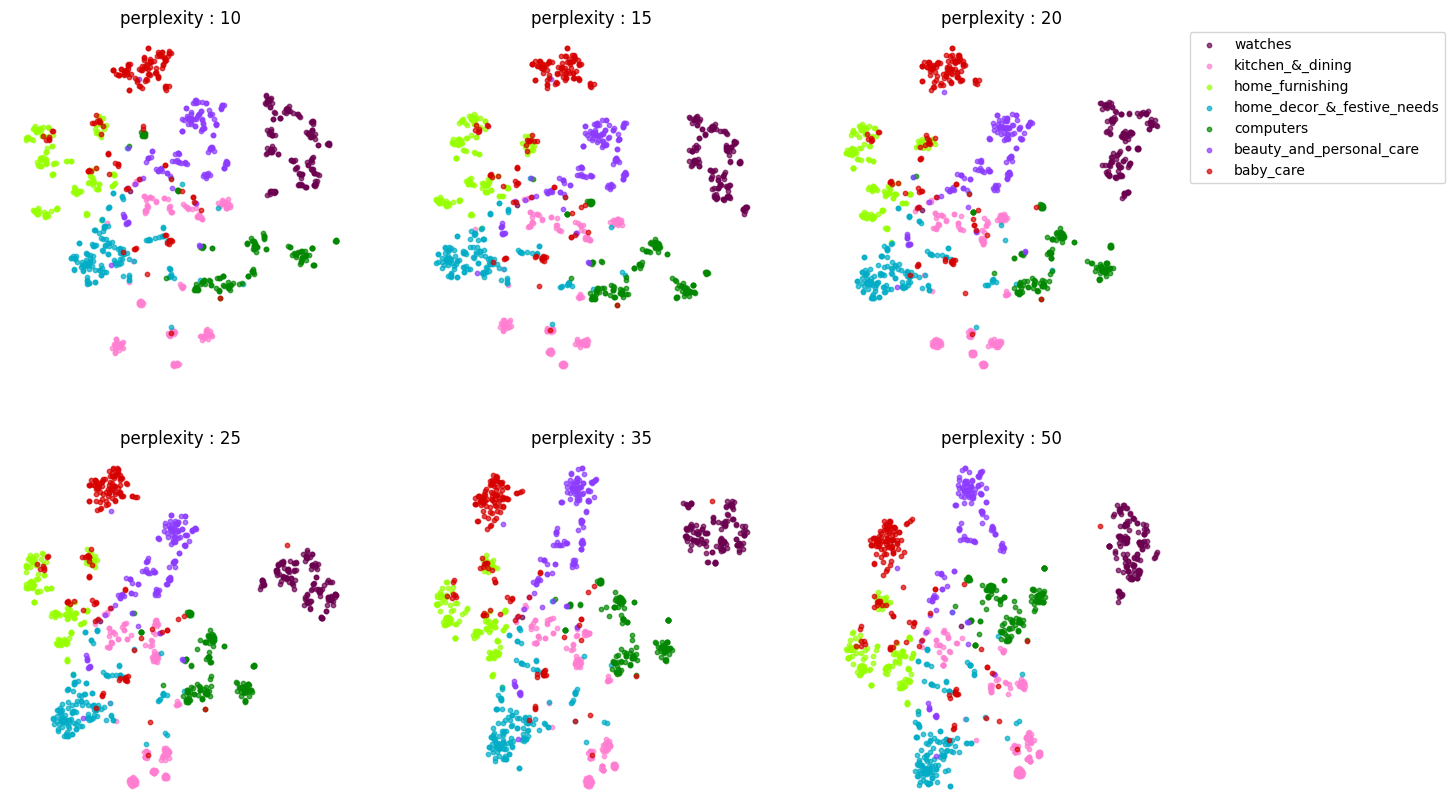

In [38]:
ds.find_tsne_best_perplexity(
    w2v_fts_norm,
    perplexities=[10, 15, 20, 25, 35, 50],
    labels=df.category
)

### 2.4.2.  [&#9650;](#toc0_) <a id='toc2_4_2_'></a>Not normalized

10
15
20
25
35
50


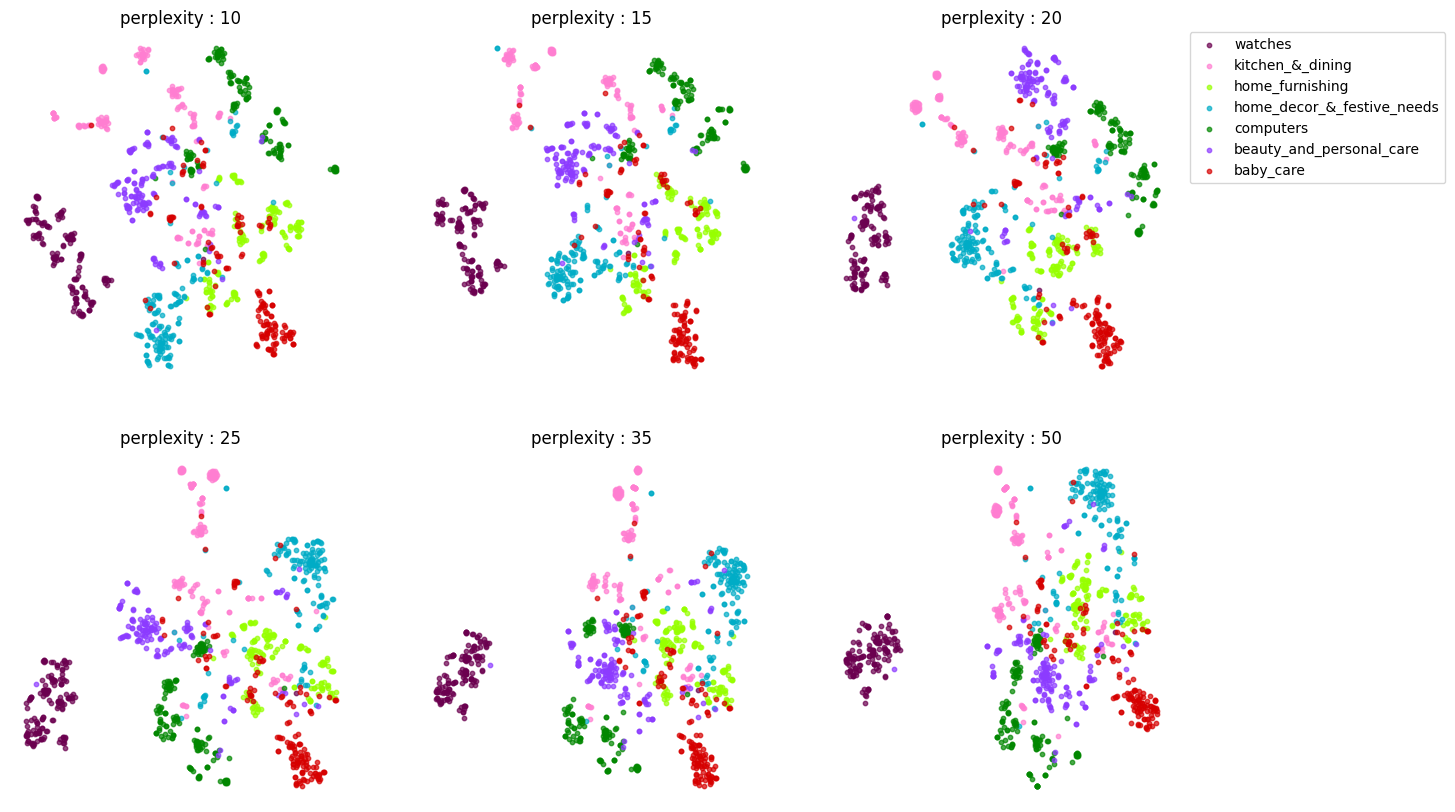

In [47]:
ds.find_tsne_best_perplexity(
    w2v_fts,
    perplexities=[10, 15, 20, 25, 35, 50],
    labels=df.category
)

In [48]:
X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(w2v_fts)

In [49]:
X_tsne_norm = TSNE(n_components=2, perplexity=30).fit_transform(w2v_fts_norm)

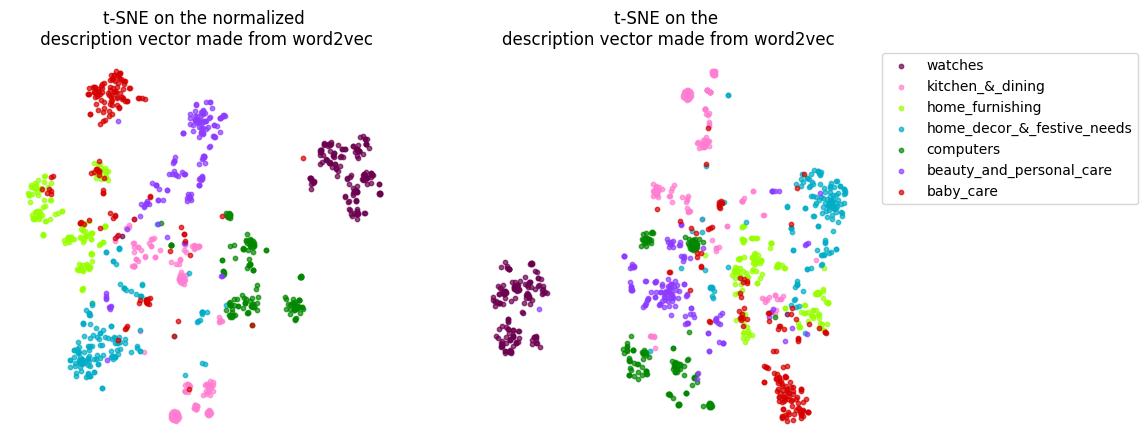

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

ds.display_tsne(
    X_tsne=X_tsne_norm,
    ax=ax[0],
    illustrative_var=df.category,
    title='t-SNE on the normalized\n description vector made from word2vec'
)
ax[0].get_legend().remove()

ds.display_tsne(
    X_tsne=X_tsne,
    ax=ax[1],
    illustrative_var=df.category,
    title='t-SNE on the \ndescription vector made from word2vec'
)

The normalized version indeed seems a bit better.

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>BERT

Unlike word2vec, BERT will not associate a word to one unique vector. The context and the attention also modulates its value.

Then, the information is pooled into one vector which I use a the description representation.

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Zero-shot classification with the HuggingFace interface

In [3]:
from transformers import pipeline

2023-05-31 10:50:54.721947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 10:50:55.112626: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 10:50:55.115006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 10:50:56.718047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
classifier = pipeline(task='zero-shot-classification')

No model was supplied, defaulted to roberta-large-mnli and revision 130fb28 (https://huggingface.co/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
2023-05-31 10:50:59.260037: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [23]:
input_text = [' '.join(df.tokens[0])]
candidate_labels = (
    pd.Series(df.category.unique())
    .str.replace('_', ' ')
    .tolist()
)
candidate_labels

['home furnishing',
 'baby care',
 'watches',
 'home decor & festive needs',
 'kitchen & dining',
 'beauty and personal care',
 'computers']

In [41]:
import time

for k in range(10):
    t0 = time.time()
    print('****')
    print(f'k : {k} / True category : {df.category[k]}')
    res = classifier([' '.join(df.tokens[k])], candidate_labels)
    print(f'time for classification : {time.time()-t0}')
    print(f'labels : {res[0]["labels"]}')
    print(f'scores : {res[0]["scores"]}')

****
k : 0 / True category : home_furnishing
time for classification : 17.86413836479187
labels : ['home furnishing', 'home decor & festive needs', 'beauty and personal care', 'baby care', 'computers', 'kitchen & dining', 'watches']
scores : [0.5417633056640625, 0.27410072088241577, 0.11362093687057495, 0.021250342950224876, 0.01905582845211029, 0.016083067283034325, 0.014125837944447994]
****
k : 1 / True category : baby_care
time for classification : 12.28412652015686
labels : ['home furnishing', 'beauty and personal care', 'baby care', 'home decor & festive needs', 'kitchen & dining', 'computers', 'watches']
scores : [0.3699895739555359, 0.36505696177482605, 0.08827676624059677, 0.058353960514068604, 0.04863988608121872, 0.035798415541648865, 0.03388439491391182]
****
k : 2 / True category : baby_care
time for classification : 21.249565362930298
labels : ['beauty and personal care', 'home furnishing', 'baby care', 'home decor & festive needs', 'computers', 'kitchen & dining', 'watch

This is expensive computation...

We see a pretty much decent classification out of the box though.

Let's explore why the model thinks baby_care products are more home furnishing

In [44]:
df.iloc[1:3, :]

,description,category,tokens
product_id,,,
7b72c92c2f6c40268628ec5f14c6d590,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care,"[sathiyas, cotton, bath, towel, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, red, yellow, blue, size, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"
64d5d4a258243731dc7bbb1eef49ad74,"Eurospa Cotton Terry Face Towel Set. Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensions Weight 350 g Length 9 inch Width 9 inch In the Box Number of Contents in Sales Package 20 Sales Package 20 PIECE FACE TOWEL SET",baby_care,"[eurospa, cotton, terry, face, towel, key, eurospa, cotton, terry, face, towel, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, piece, face, towel, assorted, eurospa, brings, exclusively, designed, soft, cotton, towel, export, quality, soft, texture, take, care, skin, give, eurospa, exporting, bath, towel, lot, brand, last, year, famous, fine, print, absorbency, durability, note, cotton, may, vary, picture, size, may, vary, wash, care, wash, cold, water, iron, bleach, flat, dry, wash, first, use, face, towel, cm, x, eurospa, cotton, terry, face, towel, piece, face, towel, assorted, bath, towel, material, cotton, terry, design, general, brand, eurospa, gsm, type, face, towel, model, ...]"


Those products are cotton towels. It is not bad to classify them as the model did.

For k=2, The fact that the second evokes skin, take care, face could indeed make us think it is about beauty and personal care. 

The presence of boy and girl might have boosted  a bit the baby care classification for k=1 

## 3.2.  [&#9650;](#toc0_) <a id='toc3_2_'></a>Sentence embeddings

In [17]:
import torch
from sentence_transformers import SentenceTransformer
# Using the mini model for fast computation.
model = SentenceTransformer('all-MiniLM-L6-v2')

2023-06-01 09:17:35,274 : INFO : Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2023-06-01 09:17:36,241 : INFO : Use pytorch device: cuda


In [18]:
corpus = df.tokens.str.join(' ')
sBERT_embeddings = model.encode(corpus)
sBERT_embeddings.shape

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

(1050, 384)

15
30
50
70
85
100


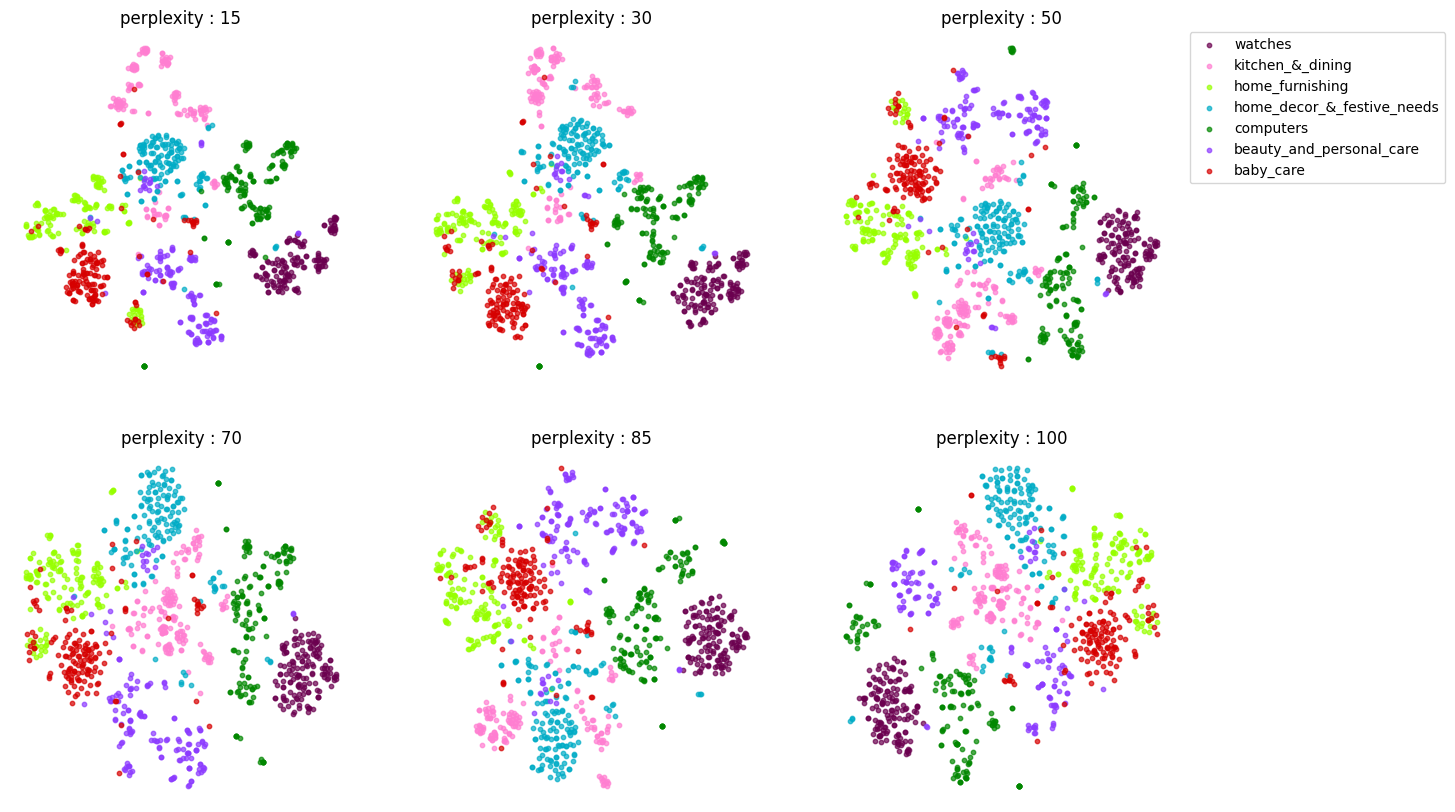

In [17]:
ds.find_tsne_best_perplexity(
    sBERT_embeddings,
    labels=df.category
)

In [21]:
X_tsne_BERT = TSNE(n_components=2, perplexity=37).fit_transform(sBERT_embeddings) 

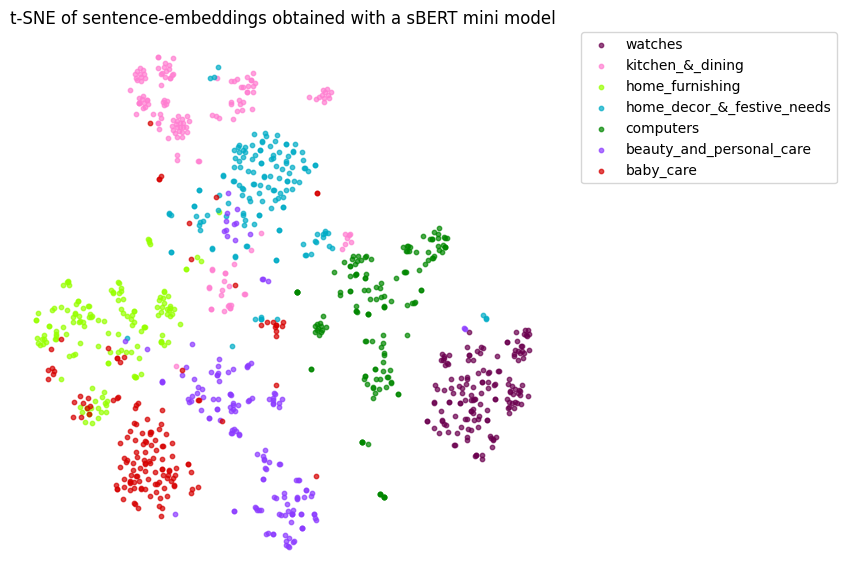

In [22]:
ds.display_tsne(
    X_tsne_BERT,
    illustrative_var=df.category,
    title='t-SNE of sentence-embeddings obtained with a sBERT mini model'
)

Nice visual separation between categories.

**Note**: 

Without the sentence-transformers package above, the same thing could have been done as followed with torch and HuggingFace transformers.

In [ ]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn.functional as F

# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# # Sentences we want sentence embeddings for
# sentences = ['This is an example sentence', 'Each sentence is converted']

# # Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')
# model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')

# # Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Perform pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# # Normalize embeddings
# sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

# print("Sentence embeddings:")
# print(sentence_embeddings)


# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>USE

In [23]:
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import os
import re

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)


2023-06-01 09:20:16.943578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 09:20:18.335850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-01 09:20:20,144 : INFO : Using /tmp/tfhub_modules to cache modules.
2023-06-01 09:20:20,147 : INFO : Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2023-06-01 09:20:35,709 : INFO : Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 650.00MB
2023-06-01 09:20:39,804 : INFO : Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
2023-06-01 09:20:39,807 : INFO : Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2023-06-01 09:20:40.269670: W ten

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [24]:
corpus = df.tokens.str.join(' ')

In [25]:
# Reduce logging output.
logging.set_verbosity(logging.ERROR)

USE_embeddings = embed(corpus)
USE_embeddings.shape


2023-06-01 09:21:21.433049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


TensorShape([1050, 512])

15
30
50
70
85
100


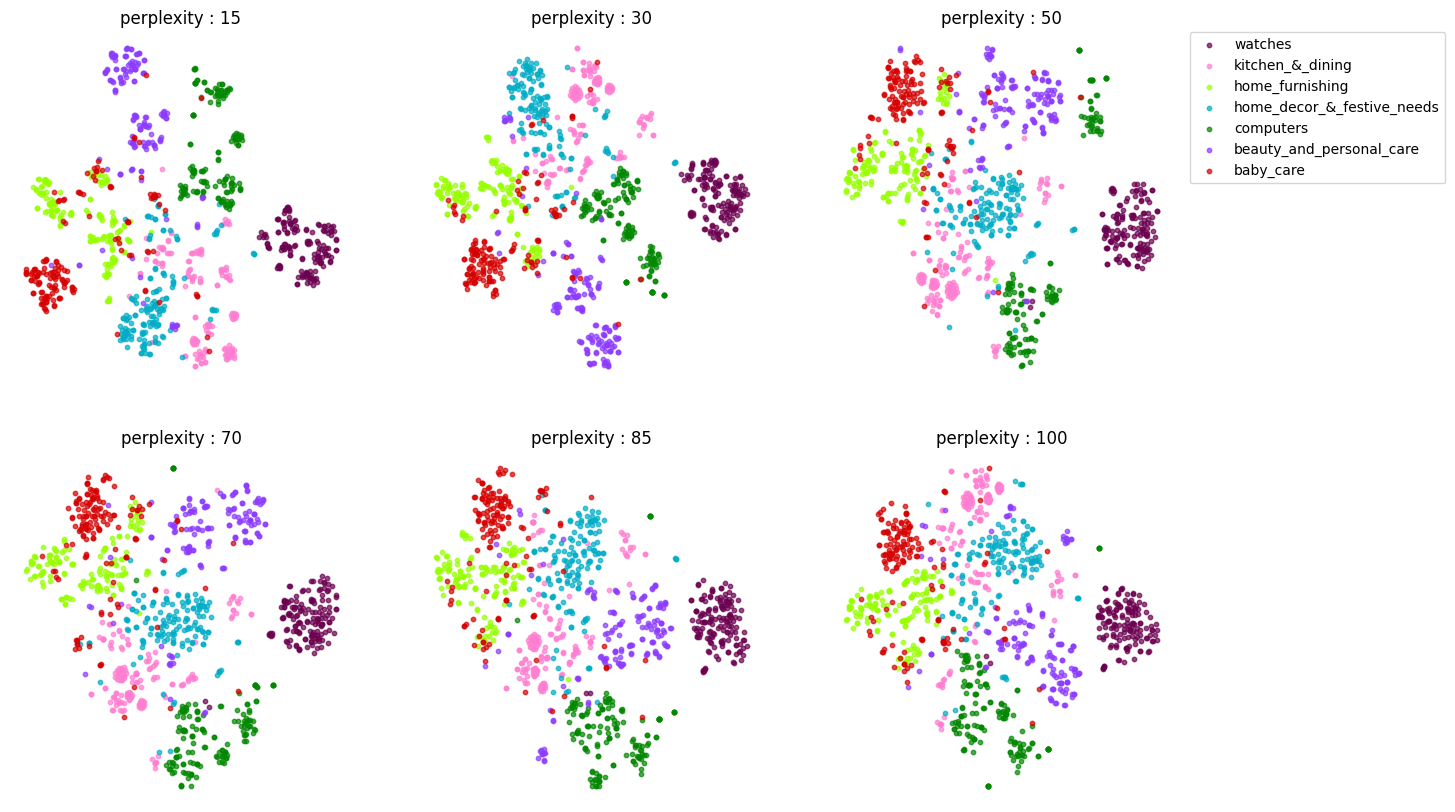

In [25]:
ds.find_tsne_best_perplexity(USE_embeddings, labels=df.category)

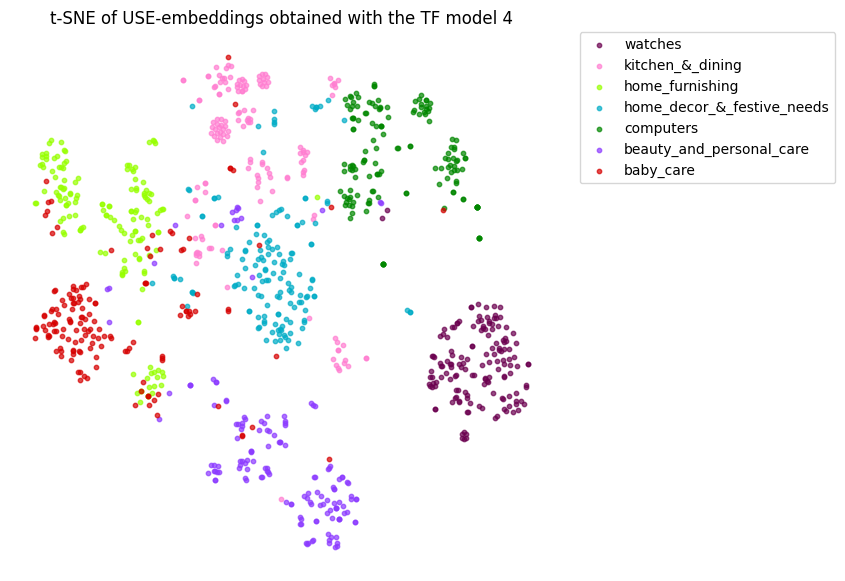

In [26]:
X_tsne_USE = TSNE(n_components=2, perplexity=35).fit_transform(USE_embeddings) 
ds.display_tsne(
    X_tsne_USE,
    illustrative_var=df.category,
    title='t-SNE of USE-embeddings obtained with the TF model 4'
)

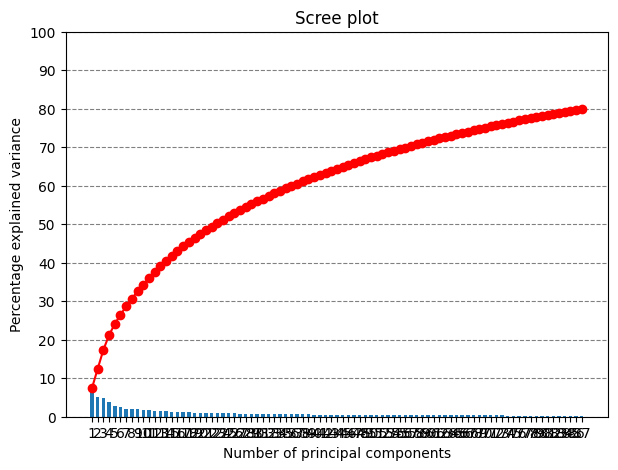

87


In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(USE_embeddings)
ds.display_scree_plot(pca)
print(pca.n_components_)
X_tsne_pca_USE = TSNE().fit_transform(X_pca)

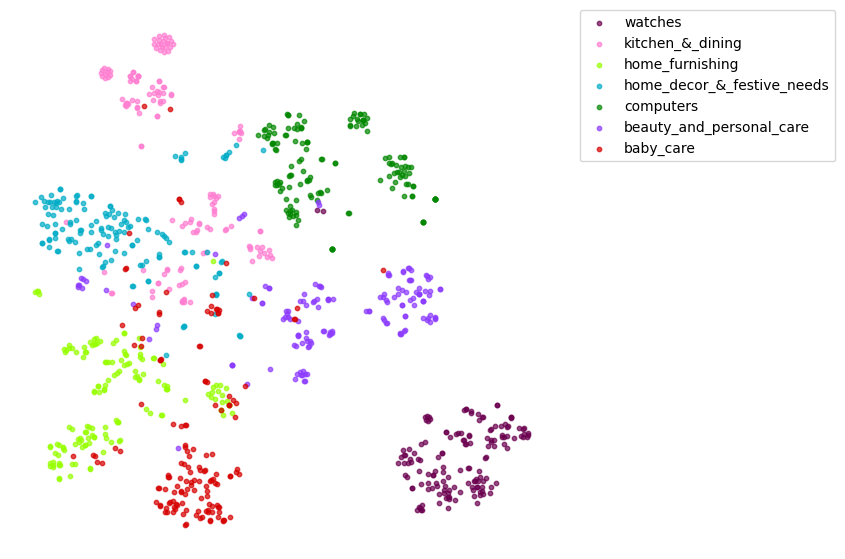

In [31]:
ds.display_tsne(X_tsne_pca_USE, illustrative_var=df.category,
                title='t-SNE on USE vectors after a PCA 80%')

In [32]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_svd = svd.fit_transform(USE_embeddings)
print(f'percentage of the variance retained :'
      f'{(svd.explained_variance_ratio_).sum()}')
X_tsne_svd_USE = TSNE().fit_transform(X_svd)

percentage of the variance retained :0.8286119103431702


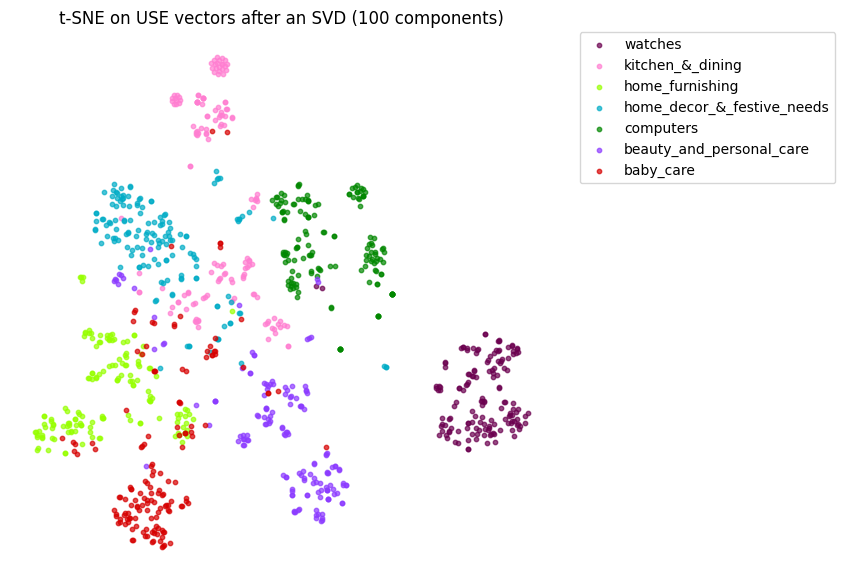

In [34]:
ds.display_tsne(X_tsne_svd_USE, illustrative_var=df.category,
                title='t-SNE on USE vectors after an SVD (100 components)')

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Evaluation

As I did before, I want to compare those models thanks to several clustering metrics; and time-wise.

There will be 2 type of time measurements.
- the time it takes to output a label knowing word/sentence embeddings. 
- time to access embeddings.

## 5.1.  [&#9650;](#toc0_) <a id='toc5_1_'></a>Scores and time

In [53]:
# Check sBERT and USE sentence vectors norms.
from random import randint

random_ks = [randint(0, len(df)) for n in range(10)]
random_ks

print('\nsBERT embeddings norms')
for vector in sBERT_embeddings[random_ks, :]:
    print(np.linalg.norm(vector))

print('\nUSE embeddings norms')
for vector in tf.gather(USE_embeddings, indices=random_ks):
    print(np.linalg.norm(vector))    
    


sBERT embeddings norms
0.99999994
1.0
0.99999994
1.0
0.99999994
0.99999994
1.0
1.0
1.0
0.99999994

USE embeddings norms
1.0
1.0
1.0
1.0
0.99999994
1.0
1.0
1.0
1.0000001
1.0


So those features are indeed normalized.

In [65]:
Xs = {
    'w2v_normalized': w2v_fts_norm,
    'w2v': w2v_fts,
    'sBERT': sBERT_embeddings,
    'USE': USE_embeddings
}

kmeans = KMeans(n_clusters=7, n_init=5)
pca = PCA(n_components=0.8)
svd = TruncatedSVD(n_components=100)
tsne = TSNE(n_components=2, perplexity=35)

pipelines = {
    'kmeans': make_pipeline(kmeans),
    'svd_kmeans': make_pipeline(svd, kmeans),
    'pca_kmeans': make_pipeline(pca, kmeans),
    'tsne_kmeans': make_pipeline(tsne, kmeans),
    'svd_tsne_kmeans': make_pipeline(svd, tsne, kmeans),
    'pca_tsne_kmeans': make_pipeline(pca, tsne, kmeans),
}

true_labels = df.category

# Results containers
evaluations = []
evaluations_std = []


# For each embeddings and pipeline, fit and evaluate clustering models scores
# and time.
for embeddings_name, embeddings in Xs.items():
    for pipe_name, pipe in pipelines.items():
        model_name = pipe_name + '\non ' + embeddings_name
        print('***********')
        print(model_name)
        ds.fit_and_evaluate_clusters(
            model=pipe,
            X=embeddings,
            labels=true_labels,
            name=model_name,
            evaluations=evaluations,
            evaluations_std=evaluations_std,
        ) 

***********
kmeans
on w2v_normalized
clustering done in 0.36 ± 0.03 s 
Homogeneity: 0.626 ± 0.009
Completeness: 0.648 ± 0.010
V-measure: 0.637 ± 0.009
Adjusted Rand-Index: 0.545 ± 0.017
Silhouette: 0.220 ± 0.002
***********
svd_kmeans
on w2v_normalized
clustering done in 0.55 ± 0.13 s 
Homogeneity: 0.626 ± 0.009
Completeness: 0.648 ± 0.010
V-measure: 0.637 ± 0.009
Adjusted Rand-Index: 0.545 ± 0.017
Silhouette: 0.220 ± 0.002
***********
pca_kmeans
on w2v_normalized
clustering done in 0.38 ± 0.02 s 
Homogeneity: 0.627 ± 0.008
Completeness: 0.652 ± 0.009
V-measure: 0.639 ± 0.008
Adjusted Rand-Index: 0.541 ± 0.018
Silhouette: 0.219 ± 0.002
***********
tsne_kmeans
on w2v_normalized
clustering done in 4.55 ± 0.36 s 
Homogeneity: 0.688 ± 0.003
Completeness: 0.710 ± 0.001
V-measure: 0.699 ± 0.002
Adjusted Rand-Index: 0.625 ± 0.003
Silhouette: 0.210 ± 0.001
***********
svd_tsne_kmeans
on w2v_normalized
clustering done in 5.60 ± 0.25 s 
Homogeneity: 0.691 ± 0.003
Completeness: 0.712 ± 0.002
V-me

In [84]:
# Convert np.float32 to float for json serialization
for elem in evaluations:
    for key, item in elem.items():
        if isinstance(item, np.float32):
            elem[key] = float(item)  
            
for elem in evaluations_std:
    for key, item in elem.items():
        if isinstance(item, np.float32):
            elem[key] = float(item)              

In [86]:
# Save results
import json
evaluations_path = './evaluations/embeddings/'
model_type = 'w2v_sBERT_USE'

with open(evaluations_path + model_type + '.json', 'w') as fp:
   json.dump(evaluations, fp, sort_keys=False, indent=4)
   
with open(evaluations_path + model_type + '_std.json', 'w') as fp:
   json.dump(evaluations_std, fp, sort_keys=False, indent=4)

## 5.2.  [&#9650;](#toc0_) <a id='toc5_2_'></a>Scores and time visualization

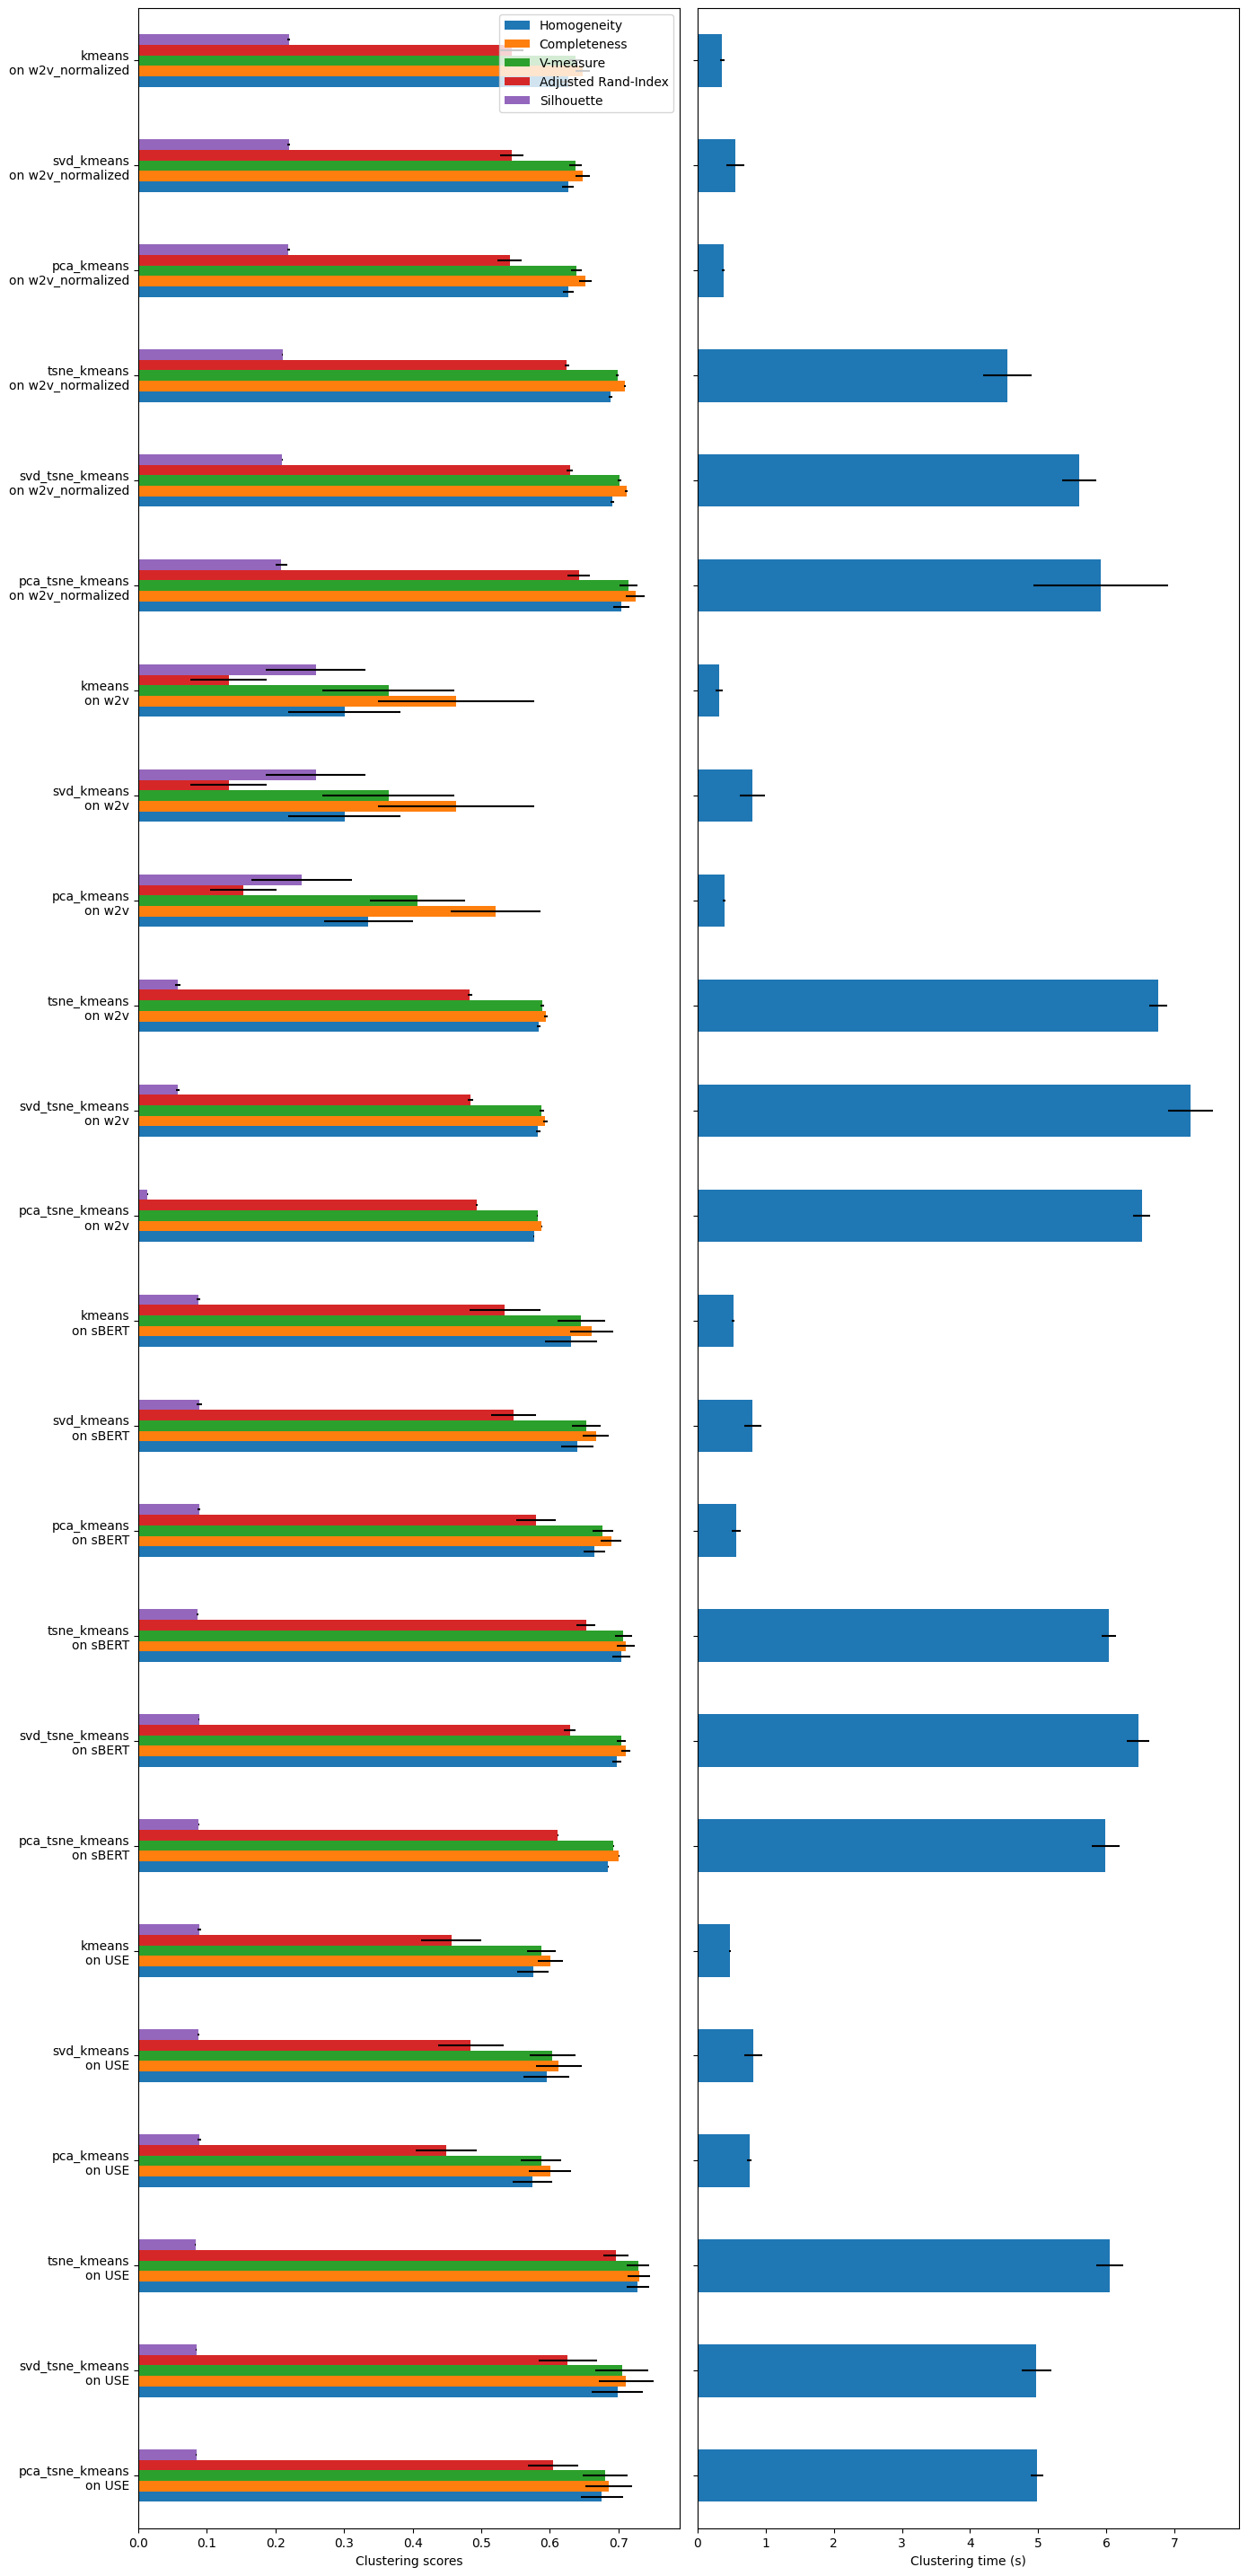

In [87]:
ds.display_clusters_scores(evaluations, evaluations_std)

**Not considering the sihlouette score**:

- For the models based on Word2Vec embeddings, normalization greatly boosted the results.
 Results are the most stable.

- For sBERT(mini) and USE(4), 
    - SBERT gives better results if I only try to cluster in the original space or in the svd or pca space.
    - USE gives the overall best results when clustering directly on the t-SNE results.

**Silhouette score** :
- Word2Vec in its normalized version gives by far the best silhouette scores.

**Time-wise**:
- The magnitude is pretty similar although it is a bit faster for W2V where tsne's and dimensionality reduction models have to work on a 100D space instead of a 384D and 512D space for the other two.

Note :

- Here, Word2Vec has been trained for few seconds on the entire dataset in an unsupervised manner.
- The other two models have been used a such (no fine-tuning).

## 2D-visualization with t-SNE

### Best word2vec model : pca_tsne_kmeans

In [126]:
embeddings = w2v_fts_norm
pipe = make_pipeline(pca, tsne)
X_tsne = pipe.fit_transform(embeddings)
kmeans_labels = kmeans.fit_predict(X_tsne)

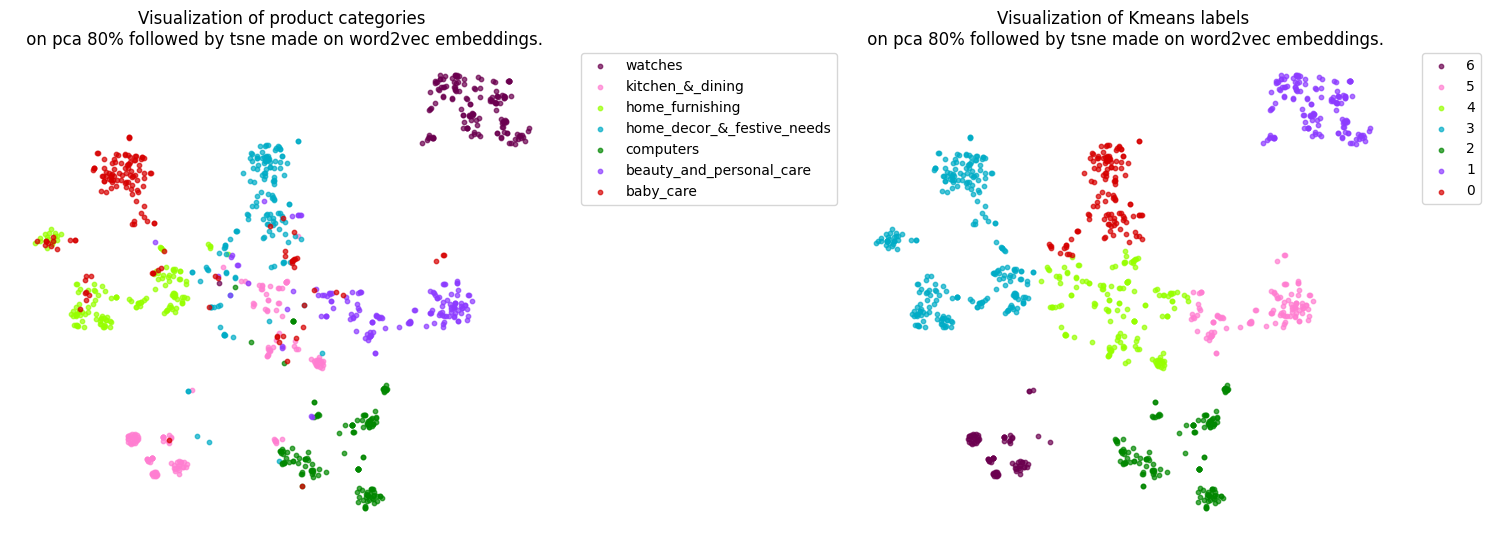

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(15,5.5))

titles = [
    (
        'Visualization of product categories\n on '
        'pca 80% '
        'followed by tsne made on word2vec embeddings.'
    ),
    
    (
        'Visualization of Kmeans labels\n on '
        'pca 80% '
        'followed by tsne made on word2vec embeddings.'
    )
]

label_vectors = [df.category, kmeans_labels]

for X_tsne, ax, label_vector, title in zip(
    [X_tsne, X_tsne],
    axes.flat,
    label_vectors,
    titles,
):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=label_vector,
        alpha=0.7,
        palette=None,
        title=title,
    )


plt.tight_layout()
plt.show()

In [128]:
from sklearn.metrics import adjusted_rand_score as ARI_score
ARI_score(kmeans_labels, df.category)

0.6287830033997024

Let's note that in the center, a lot of kitchen and dining products are attached to other categories.
I want to add one cluster and see If I cant catch that.

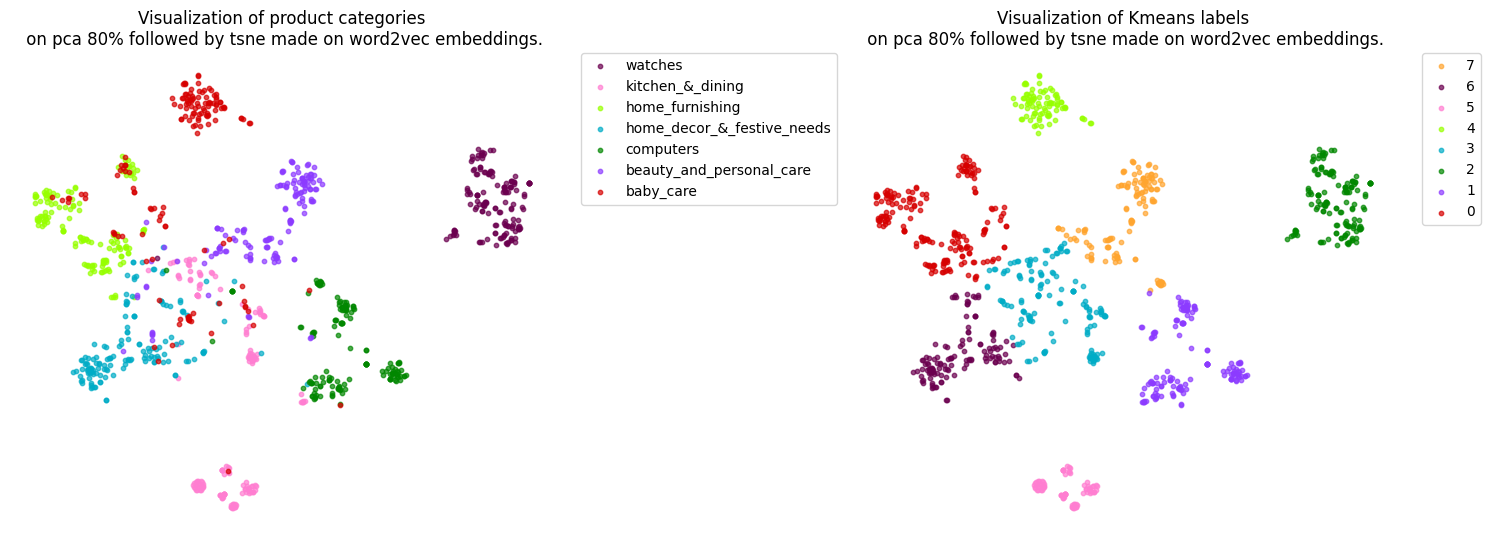

In [129]:
embeddings = w2v_fts_norm
pipe = make_pipeline(pca, tsne)
X_tsne = pipe.fit_transform(embeddings)
kmeans_labels = KMeans(n_clusters=8, n_init=5).fit_predict(X_tsne)
fig, axes = plt.subplots(1, 2, figsize=(15,5.5))

titles = [
    (
        'Visualization of product categories\n on '
        'pca 80% '
        'followed by tsne made on word2vec embeddings.'
    ),
    
    (
        'Visualization of Kmeans labels\n on '
        'pca 80% '
        'followed by tsne made on word2vec embeddings.'
    )
]

label_vectors = [df.category, kmeans_labels]

for X_tsne, ax, label_vector, title in zip(
    [X_tsne, X_tsne],
    axes.flat,
    label_vectors,
    titles,
):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=label_vector,
        alpha=0.7,
        palette=None,
        title=title,
    )


plt.tight_layout()
plt.show()

Now, if I join cluster 1 and 7, what is the score ?

In [130]:
kmeans_labels[kmeans_labels == 5] = 3
np.unique(kmeans_labels)

array([0, 1, 2, 3, 4, 6, 7], dtype=int32)

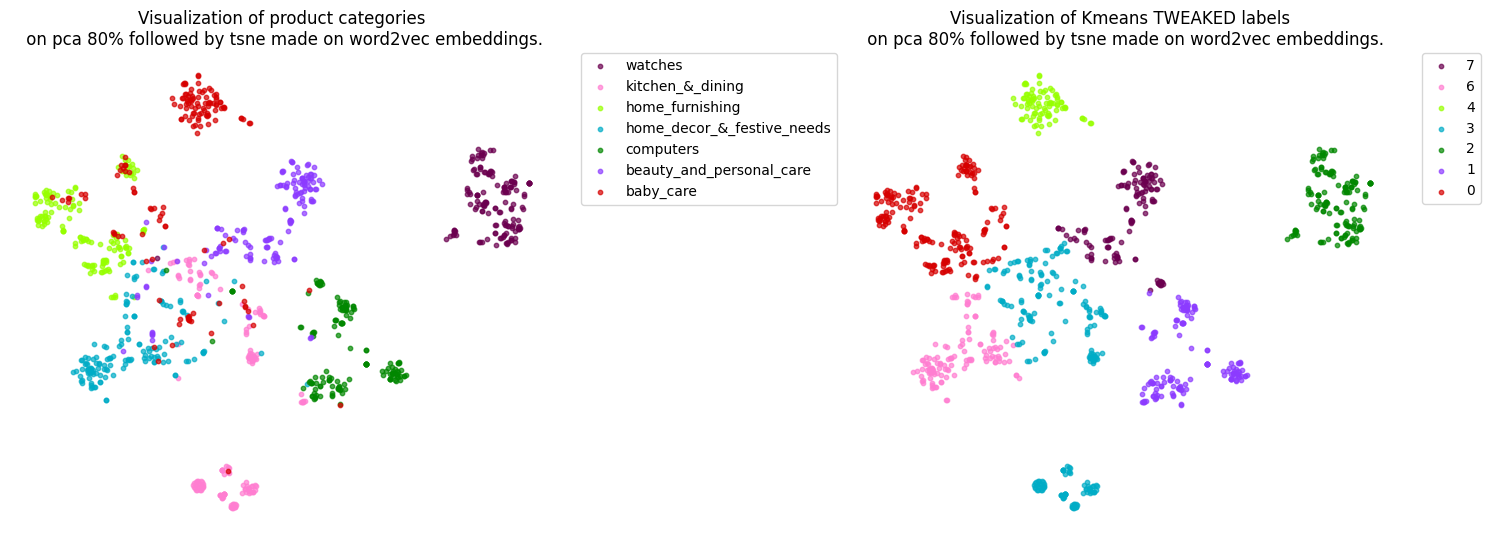

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15,5.5))

titles = [
    (
        'Visualization of product categories\n on '
        'pca 80% '
        'followed by tsne made on word2vec embeddings.'
    ),
    
    (
        'Visualization of Kmeans TWEAKED labels \n on '
        'pca 80% '
        'followed by tsne made on word2vec embeddings.'
    )
]

label_vectors = [df.category, kmeans_labels]

for X_tsne, ax, label_vector, title in zip(
    [X_tsne, X_tsne],
    axes.flat,
    label_vectors,
    titles,
):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=label_vector,
        alpha=0.7,
        palette=None,
        title=title,
    )


plt.tight_layout()
plt.show()

In [132]:
ARI_score(kmeans_labels, df.category)

0.6688357628121872

There I can increase the ARI score from 0.62 to almost 0.67!

### Best sBERT model : tsne_kmeans

In [122]:
embeddings = sBERT_embeddings
pipe = make_pipeline(tsne)
X_tsne = pipe.fit_transform(embeddings)
kmeans_labels = kmeans.fit_predict(X_tsne)

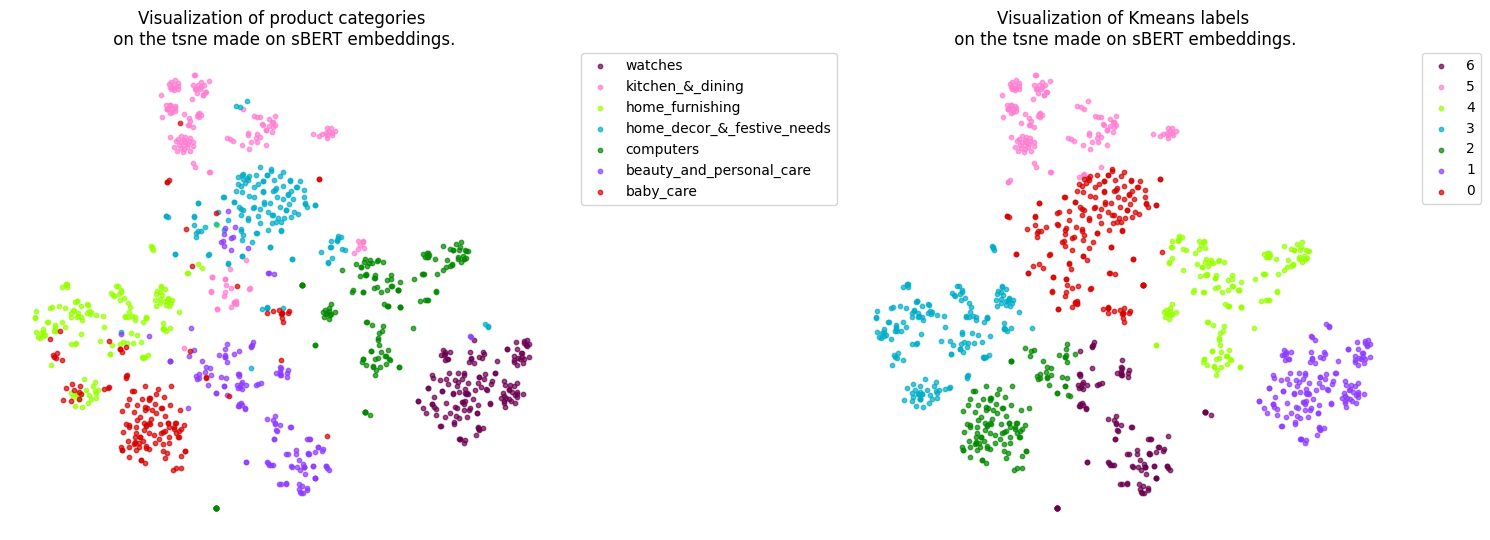

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(15,5.5))

titles = [
    (
        'Visualization of product categories\n on '
        'the tsne made on sBERT embeddings.'
    ),
    
    (
        'Visualization of Kmeans labels\n on '
        'the tsne made on sBERT embeddings.'
    )
]

label_vectors = [df.category, kmeans_labels]

for X_tsne, ax, label_vector, title in zip(
    [X_tsne, X_tsne],
    axes.flat,
    label_vectors,
    titles,
):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=label_vector,
        alpha=0.7,
        palette=None,
        title=title,
    )


plt.tight_layout()
plt.show()

In [123]:
ARI_score(kmeans_labels, df.category)

0.669555993318743

### Best USE model : tsne_kmeans

In [124]:
embeddings = USE_embeddings
pipe = make_pipeline(tsne)
X_tsne = pipe.fit_transform(embeddings)
kmeans_labels = kmeans.fit_predict(X_tsne)

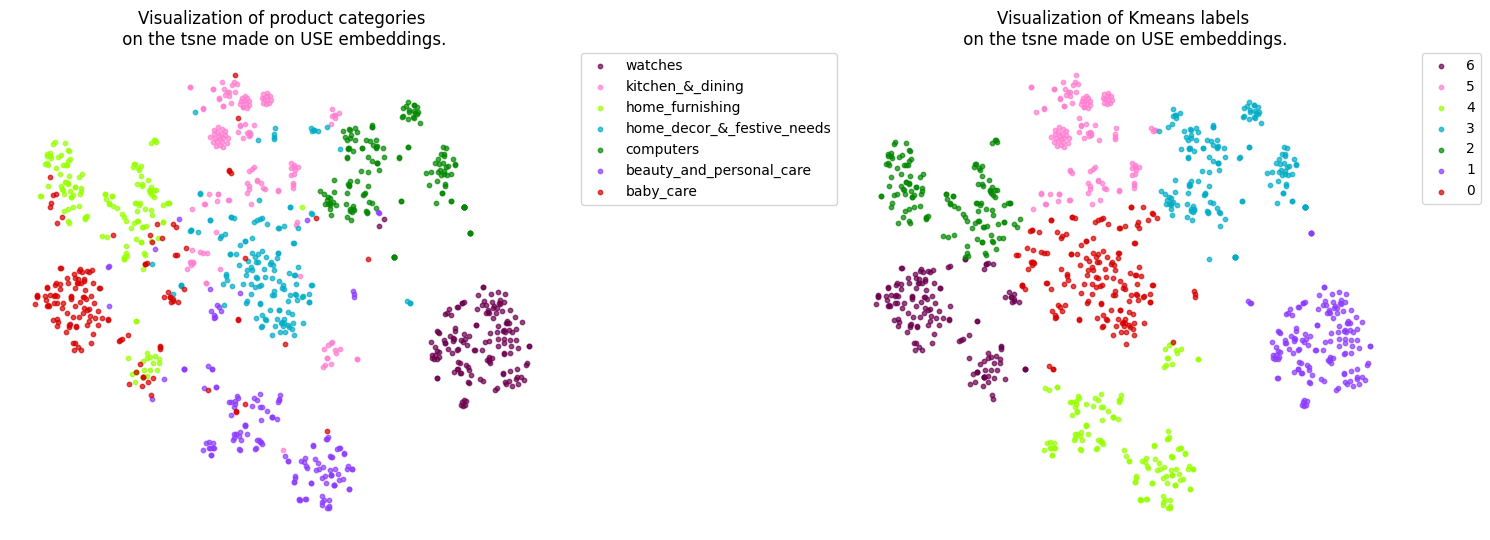

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15,5.5))

titles = [
    (
        'Visualization of product categories\n on '
        'the tsne made on USE embeddings.'
    ),
    
    (
        'Visualization of Kmeans labels\n on '
        'the tsne made on USE embeddings.'
    )
]

label_vectors = [df.category, kmeans_labels]

for X_tsne, ax, label_vector, title in zip(
    [X_tsne, X_tsne],
    axes.flat,
    label_vectors,
    titles,
):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=label_vector,
        alpha=0.7,
        palette=None,
        title=title,
    )


plt.tight_layout()
plt.show()

In [125]:
ARI_score(kmeans_labels, df.category)

0.6917214491890278

In [104]:
pd.DataFrame(evaluations).sort_values('Adjusted Rand-Index', ascending=False)

,estimator,train_time,Homogeneity,Completeness,V-measure,Adjusted Rand-Index,Silhouette
21,tsne_kmeans\non USE,6.052678,0.728230,0.729759,0.728994,0.696381,0.083500
15,tsne_kmeans\non sBERT,6.037781,0.704349,0.710481,0.707400,0.652856,0.086200
5,pca_tsne_kmeans\non w2v_normalized,5.919033,0.704376,0.724911,0.714495,0.642061,0.208591
4,svd_tsne_kmeans\non w2v_normalized,5.603504,0.691144,0.711654,0.701248,0.629093,0.209708
16,svd_tsne_kmeans\non sBERT,6.468382,0.697219,0.710843,0.703963,0.628959,0.088800
22,svd_tsne_kmeans\non USE,4.972367,0.698648,0.711320,0.704924,0.625797,0.084600
3,tsne_kmeans\non w2v_normalized,4.548969,0.687948,0.709580,0.698596,0.624950,0.210295
17,pca_tsne_kmeans\non sBERT,5.991726,0.685020,0.700724,0.692783,0.611832,0.088100
23,pca_tsne_kmeans\non USE,4.979321,0.675631,0.685985,0.680766,0.604782,0.084600
14,pca_kmeans\non sBERT,0.562626,0.665204,0.689690,0.677223,0.579728,0.088400
